## Import libraries

In [1]:
import os
from pathlib import Path
import glob
from raster4ml.preprocessing import stack_bands
from raster4ml.plotting import Map

from pyspatialml import Raster
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import randint, uniform
import pandas as pd
import geopandas as gpd
import tempfile
import rasterio
import cv2

# Machine learning Modelling 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from joblib import dump, load

In [2]:
def list_tif_files(dir_path):
    """
    List all .tif files in the specified directory.

    Parameters:
    dir_path (str): Path to the directory containing raster files.

    Returns:
    list: A list of file paths for all .tif files in the directory.
    """
    # List to store .TIF file paths
    tif_files = []

    # Iterate through the directory and add .TIF files to the list
    for filename in os.listdir(dir_path):
        if filename.lower().endswith('.tif'):
            tif_files.append(os.path.join(dir_path, filename))

    return tif_files


In [3]:
# Preprocess raster to have the same extent and coordinate reference systems

def preprocess_raster(input_path, output_path, target_shape):
    with rasterio.open(input_path) as src:
        # Read and convert to float32
        raster_data = src.read(1).astype(np.float32)
        nodata = src.nodatavals[0] if src.nodatavals[0] is not None else 0
        raster_data[raster_data == np.nan] = np.nan

        # Resize image to target_shape
        resized_raster = cv2.resize(raster_data, target_shape, interpolation=cv2.INTER_NEAREST)

        # Write the data to a new file
        with rasterio.open(
            output_path, 'w',
            driver='GTiff',
            height=target_shape[1],
            width=target_shape[0],
            count=1,
            dtype=resized_raster.dtype,
            crs=src.crs,
            transform=src.transform
        ) as dst:
            dst.write(resized_raster, 1)

# Define the target shape (width, height) - replace with your desired dimensions
target_shape = (10505, 10426) #ValueError: could not broadcast input array from shape (10426,10505) into shape (10505,10426)

# Paths to your raster files and the output directory
original_files = list_tif_files("Raster-Layers")
 
output_dir = Path(r"Modified-Rasters") # Change the path to modify Modified Rasters later

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Preprocess each raster
for file in original_files:
    output_path = os.path.join(output_dir, os.path.basename(file))
    preprocess_raster(file, output_path, target_shape)


In [3]:
# Create a stack band 

stack = Raster(list_tif_files(dir_path = 'Modified-Rasters'))

In [5]:
stack.names

dict_keys(['Aspect', 'builtuparea', 'Elevation', 'LST', 'LULCC', 'NDVI', 'NDWI', 'PopDensity', 'Poverty', 'Precipitation', 'Slope'])

In [6]:
# Store a stack band to a file for further processing

stack.write(file_path= "Cholera-data-reshaped/stacked-band.tif", nodata = 0)

Raster Object Containing 11 Layers
    attribute                                             values
0       names  [Aspect, builtuparea, Elevation, LST, LULCC, N...
1       files  [Cholera-data-reshaped/stacked-band.tif, Chole...
2        rows                                              10426
3        cols                                              10505
4         res                                       (30.0, 30.0)
5  nodatavals  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...


In [3]:
# Define the map instance
m = Map()
# Add the raster to the map
m.add_raster(image_path="Cholera-data-reshaped/stacked-band.tif", bands=[4, 3, 2])
m

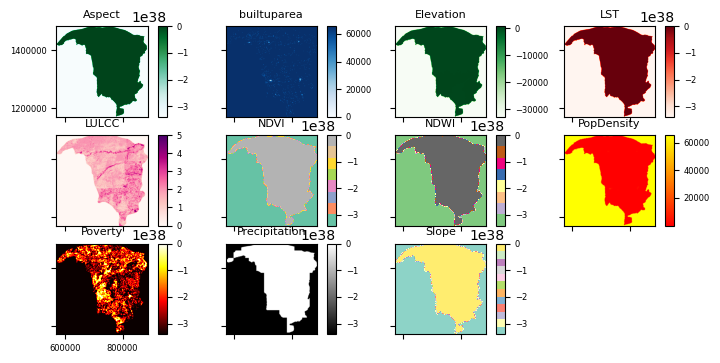

In [5]:
# Visualize each band in the stacked raster file

stack.Aspect.cmap = "BuGn"
stack.builtuparea.cmap = "Blues"
stack.Elevation.cmap = "Greens"
stack.LST.cmap = "Reds"
stack.LULCC.cmap = "RdPu"
stack.PopDensity.cmap = "autumn"
stack.Poverty.cmap = "hot"
stack.Precipitation.cmap = "gist_gray"
stack.Slope.cmap = "Set3"
stack.NDVI.cmap = "Set2"
stack.NDWI.cmap = "Accent"
stack.plot(
    title_fontsize=8,
    label_fontsize=6,
    legend_fontsize=6,
    fig_kwds={"figsize": (8, 4)},
    subplots_kwds={"wspace": 0.5}
)

plt.show()


# a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

In [6]:
# Load your vector data

population_cholera = gpd.read_file("Vector-Layers/Population_Cholera.shp")

In [7]:
population_cholera

,ward_name,lga_name,wardPOP,CHLcases,Area,pop_dense,geometry
0,Sasawa/Kabaru,Damaturu,22380,13,586,38,"POLYGON ((12.09087 12.14448, 12.09713 12.12852..."
1,Gwio-Kura,Bade,24021,0,530,45,"POLYGON ((11.11216 12.79503, 11.14683 12.77250..."
2,Mutai,Gujba,18149,105,426,43,"POLYGON ((11.58056 11.31168, 11.58270 11.32787..."
3,Ma'anna,Geidam,17552,0,394,45,"POLYGON ((11.80239 12.69811, 11.78623 12.71379..."
4,Sarkin Hausawa,Bade,6515,0,20,326,"POLYGON ((11.09329 12.84809, 11.09264 12.84752..."
...,...,...,...,...,...,...,...
173,Zajibiriri/Dumbol,Yunusari,16155,0,260,62,"POLYGON ((11.87034 13.10548, 11.87680 13.07531..."
174,Maisandari/Waziri Ibrahim,Damaturu,29762,9,179,166,"POLYGON ((12.06825 11.82453, 12.06236 11.82296..."
175,Buni Yadi,Gujba,42064,107,207,203,"POLYGON ((11.99902 11.33805, 12.01531 11.32656..."
176,Dadingel,Gujba,4905,0,157,31,"POLYGON ((12.20911 11.61220, 12.23234 11.60706..."


In [14]:
population_cholera.describe()

,wardPOP,CHLcases,Area,pop_dense
count,178.000000,178.000000,178.000000,178.000000
mean,18441.561798,13.275281,257.769663,679.140449
std,12626.889097,36.814508,212.198441,2227.507725
min,2580.000000,0.000000,2.000000,12.000000
25%,10834.500000,0.000000,91.000000,42.250000
50%,15843.500000,0.000000,201.500000,71.000000
75%,22114.000000,8.000000,369.250000,147.500000
max,109728.000000,303.000000,1156.000000,15012.000000


In [15]:
pop_cho = population_cholera.iloc[:, [0, 1, 3, 6]]

# Add an ID column before 'ward_name'

pop_cho.insert(0, 'ID', range(1, len(population_cholera) + 1))

pop_cho = pop_cho.to_crs(stack.crs)

pop_cho.head()

,ID,ward_name,lga_name,CHLcases,geometry
0,1,Sasawa/Kabaru,Damaturu,13,"POLYGON ((836438.300 1344440.935, 837140.938 1..."
1,2,Gwio-Kura,Bade,0,"POLYGON ((729279.369 1415405.533, 733065.122 1..."
2,3,Mutai,Gujba,105,"POLYGON ((781698.140 1251687.471, 781916.630 1..."
3,4,Ma'anna,Geidam,0,"POLYGON ((804368.929 1405388.768, 802593.194 1..."
4,5,Sarkin Hausawa,Bade,0,"POLYGON ((727182.477 1421260.280, 727112.033 1..."


In [16]:
pop_cho.to_file('Cholera-data-reshaped/cholera_modified.shp')

## R programming 

**The remaining work was done in R because the extraction of raster was not working in Python. I have tried many modules such as raster4ml.extraction and pyspatialml.extract_vector**

To follow along, you will need to first [install R](https://cran.r-project.org/bin/windows/base/R-4.3.2-win.exe) and [RStudio](https://download1.rstudio.org/electron/windows/RStudio-2023.12.1-402.exe) if you have done that before. Then open the `Cholera Project.Rproj` R programming file. This will open the **Cholera Project** RStudio project. Then open `R-Project-Script.R` which contains the R codes. When you are done in R then continue with the section below:

## Python

In [2]:
# Load your vector data

data_analysis = gpd.read_file("data-analysis/analysis_data.shp")

data_analysis.head()

,ID,Aspect,builtpr,Elevatn,LST,LULCC,NDVI,NDWI,PpDnsty,Poverty,Prcpttn,Slope,ward_nm,lga_nam,CHLcass,geometry
0,46.0,336.801422,65535.0,343.0,39.714725,2.0,1.397966e-01,-3.043458e-01,131.0,9.542786e+01,8.0,1.817522,Afunori,Nguru,0.0,"POLYGON ((651047.608 1447587.245, 648788.949 1..."
1,46.0,206.565048,65535.0,341.0,39.033237,2.0,1.562621e-01,-3.054383e-01,131.0,-3.402823e+22,8.0,3.199601,Afunori,Nguru,0.0,"POLYGON ((651047.608 1447587.245, 648788.949 1..."
2,46.0,344.744873,65535.0,338.0,39.742535,2.0,1.284416e-01,-2.740523e-01,131.0,9.493150e+01,8.0,2.719923,Afunori,Nguru,0.0,"POLYGON ((651047.608 1447587.245, 648788.949 1..."
3,46.0,23.198589,65535.0,344.0,37.672096,2.0,-3.402823e+22,-3.402823e+22,131.0,8.533812e+01,8.0,3.631394,Afunori,Nguru,0.0,"POLYGON ((651047.608 1447587.245, 648788.949 1..."
4,46.0,113.198593,65535.0,343.0,37.773144,1.0,-3.402823e+22,-2.921346e-01,131.0,9.443478e+01,8.0,1.817522,Afunori,Nguru,0.0,"POLYGON ((651047.608 1447587.245, 648788.949 1..."


In [3]:
data_analysis.shape

(1011839, 16)

# Preprocessing Steps:

- Handle Geospatial Data: Convert the geometry column to features that can be used by regression models (e.g., area, perimeter, centroid coordinates).
- Scaling Numerical Features: Scale the numerical features to ensure no variable dominates because of its scale.
- Handle Missing Values: Impute or remove missing values.
- Feature Engineering: Create new features that might help improve model performance.
- Data Splitting: Split the data into training and test sets.

# Models to Train:

- Random Forest Regression: This ensemble learning method is good for handling complex datasets with a mix of variable types. It can capture non-linear relationships between features and the target variable. Random Forest is also less prone to overfitting and can handle missing values, which might be beneficial for complex geospatial data.

- Gradient Boosting Machines (GBM): Models like XGBoost, LightGBM, or CatBoost are powerful for classification tasks and can deal with various types of data. They sequentially build weak learners to form a strong predictive model and can handle the intricacies in the data, improving accuracy significantly.

- Support Vector Machines (SVM): SVM can be particularly useful for binary classification problems (like predicting the presence or absence of cholera cases). It works well with high-dimensional data and can model complex relationships by using different kernel functions.

- Deep Learning Models (Convolutional Neural Networks - CNNs): For spatial data, especially when working with raster data (like LST or elevation maps), CNNs can extract spatial hierarchies and patterns effectively. These models can be adapted to work with both spatial and non-spatial features, offering a comprehensive analysis of factors influencing cholera outbreaks.

- Geographically Weighted Regression (GWR): This is more of a statistical approach than machine learning, but GWR is beneficial for modeling spatial data since it allows the relationships between the predictors and the outcome to vary across space. This model can help understand how the influence of different factors on cholera cases changes across different locations.


## Data Preprocessing

In [4]:
# Extracting numerical features and target variable

X = data_analysis.drop(['ID', 'ward_nm', 'lga_nam', 'CHLcass', 'geometry'], axis=1)
y = data_analysis['CHLcass']

# Splitting the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Random Forest

In [5]:
rf_param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(4, 10),  # Consider None as well if you want to include unlimited depth
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'bootstrap': [True, False]
}

In [6]:
rf = RandomForestRegressor(random_state=42)

rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions= rf_param_dist, n_iter= 4, cv=5, 
                                   n_jobs=-1, scoring='neg_mean_squared_error', random_state=42, verbose=2)
rf_random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=4, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000026CC7ECBA50>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000026CC7ECC390>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000026CC7ECBDD0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000026CC7EC82D0>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [7]:
# The best estimator

best_random_forest = rf_random_search.best_estimator_

### Saving the model

In [13]:
# Save the model

dump(best_random_forest, 'Models/best_random_forest.joblib')

['Models/best_random_forest.joblib']

In [5]:
# Load the model

best_random_forest = load('Models/best_random_forest.joblib')

In [6]:
# Retrieve feature importance from the model 

importances = best_random_forest.feature_importances_

# Match Feature Importances with Feature Names

feature_names = X_train.columns

feature_importance_dict = dict(zip(feature_names, importances))

# Sort the features by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print sorted feature importance
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")


PpDnsty: 0.5804355895715204
Elevatn: 0.28285082440716597
LULCC: 0.13077649391361754
Poverty: 0.003911592518946759
Prcpttn: 0.0017420728376921558
NDVI: 0.00019846865977640938
Slope: 4.7796922717104805e-05
Aspect: 2.688833978073243e-05
LST: 7.579759303208545e-06
NDWI: 1.786721362604094e-06
builtpr: 9.063481169119427e-07


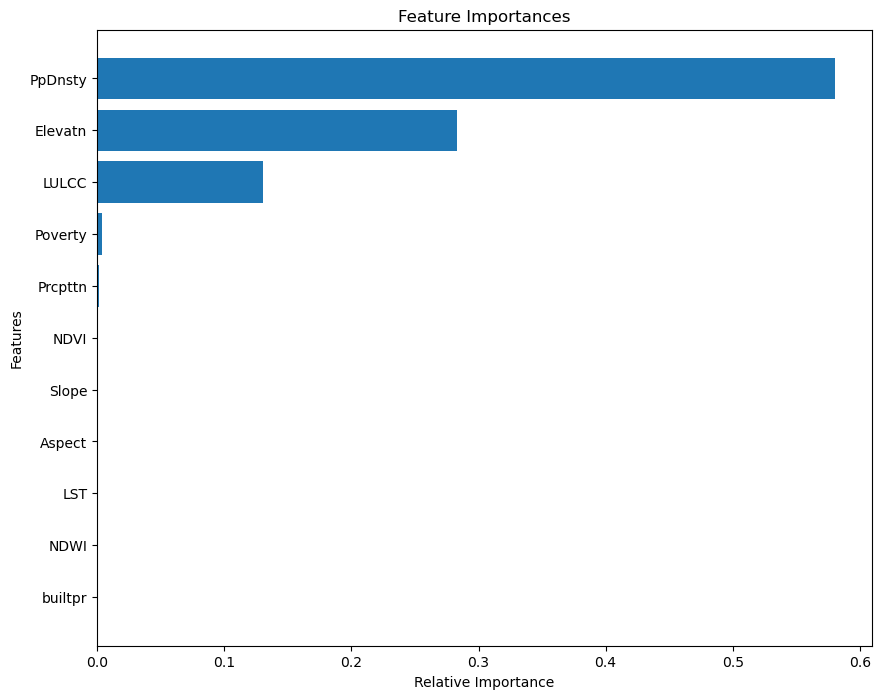

In [7]:
# Extract feature names and their importance values
features, importance = zip(*sorted_feature_importance)

plt.figure(figsize=(10, 8))
plt.barh(features, importance)
plt.xlabel("Relative Importance")
plt.ylabel("Features")
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

In [8]:
random_forest_pred = best_random_forest.predict(X_test_scaled)

In [9]:
# Evaluation metrics

mae = mean_absolute_error(y_test, random_forest_pred)
mse = mean_squared_error(y_test, random_forest_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, random_forest_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"_Root Mean Squared Error (RMSE)_: {rmse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 10.810561049767786
Mean Squared Error (MSE): 614.2328348416829
_Root Mean Squared Error (RMSE)_: 24.783721166154265
R-squared (R2): 0.7054609650440631


## Gradient Boosting Machines: xgboost

In [10]:
xgb_param_dist = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'colsample_bytree': uniform(0.5, 0.45),
    'min_child_weight': randint(1, 6),
    'alpha': uniform(0, 10)
}

In [11]:
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)

xgb_random_search = RandomizedSearchCV(estimator=xgb_reg, param_distributions=xgb_param_dist, n_iter= 4, 
                                   scoring='neg_mean_squared_error', cv= 5, verbose=2, random_state=42, n_jobs=-1)

xgb_random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C538E3E6D0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C534E57AD0>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C537400110>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C538E3E310>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [12]:
# The best estimator

best_xgb = xgb_random_search.best_estimator_


### Saving the model

In [13]:
# Save the model

dump(best_xgb, 'Models/best_xgb.joblib')

['Models/best_xgb.joblib']

In [14]:
# Load the model

best_xgb = load('Models/best_xgb.joblib')

In [15]:
# Retrieve feature importance from the model 

feature_importances = best_xgb.feature_importances_

# Match feature names with their importances
features = X_train.columns
importance_dict = dict(zip(features, feature_importances))

# Sort features by importance
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Unpacking for plotting
sorted_features, sorted_scores = zip(*sorted_importance)


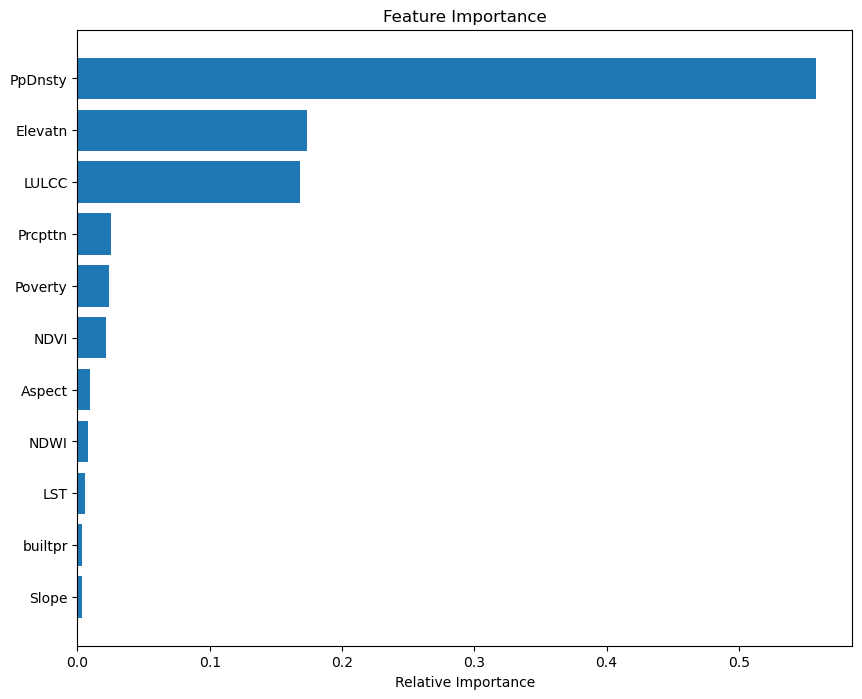

In [16]:
# The plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_features)), sorted_scores, align='center')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.gca().invert_yaxis()  # Most important at the top
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

In [17]:
xgb_pred = best_xgb.predict(X_test_scaled)

In [18]:
# Evaluation metrics

mae = mean_absolute_error(y_test, xgb_pred)
mse = mean_squared_error(y_test, xgb_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, xgb_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"_Root Mean Squared Error (RMSE)_: {rmse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 6.96022141276451
Mean Squared Error (MSE): 374.9639307363372
_Root Mean Squared Error (RMSE)_: 19.363985404258525
R-squared (R2): 0.8201960103112501


## Gradient Boosting Machines: LightGBM

In [19]:
lgb_param_dist = {
    'num_leaves': randint(20, 200),
    'min_child_samples': randint(100, 500),
    'min_child_weight': [1e-5, 1e-3, 0.1, 1, 100],
    'subsample': uniform(loc=0.2, scale=0.8),  # Bagging fraction
    'colsample_bytree': uniform(loc=0.4, scale=0.6),  # Feature fraction
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50],  # L1 regularization
    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50],  # L2 regularization
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

In [20]:
lgb_reg = lgb.LGBMRegressor(random_state=42, n_estimators=500)

lgb_random_search = RandomizedSearchCV(estimator=lgb_reg, param_distributions=lgb_param_dist, n_iter= 4, 
                                   scoring='neg_mean_squared_error', cv=5, verbose=2, random_state=42, n_jobs=-1)

lgb_random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 809471, number of used features: 11
[LightGBM] [Info] Start training from score 18.330137


RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(n_estimators=500, random_state=42),
                   n_iter=4, n_jobs=-1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C538E15250>,
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'min_child_samples': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C...
                                        'min_child_weight': [1e-05, 0.001, 0.1,
                                                             1, 100],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C5373F56D0>,
                                        'reg_alpha': [0, 0.1, 1, 2, 5, 7, 10,
                                                      50],
                                        'reg_lambda': [0, 0.1, 1, 5, 10, 20,
                                                       50],
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C5362D2510>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [22]:
# The best estimator

best_lgb = lgb_random_search.best_estimator_

### Saving the model

In [24]:
# Save the model

dump(best_lgb, 'Models/best_lgb.joblib')

['Models/best_lgb.joblib']

In [25]:
# Load the model

best_lgb = load('Models/best_lgb.joblib')

In [27]:
# Retrieve feature importances from the model

feature_importances = best_lgb.feature_importances_

# Sort the feature importances in descending order

sorted_indices = np.argsort(feature_importances)[::-1]


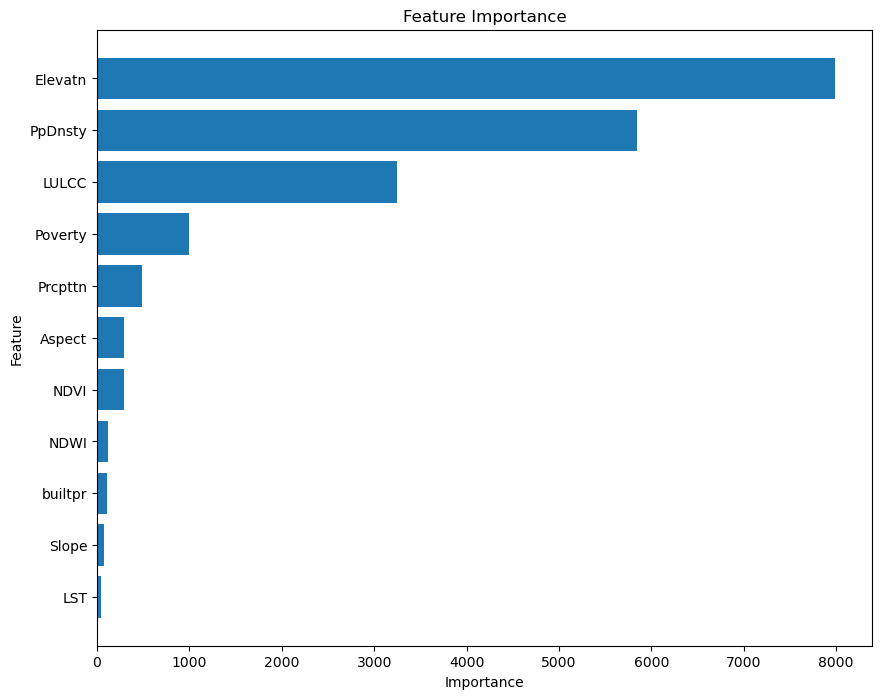

In [38]:
# The plot

plt.figure(figsize=(10, 8))
plt.title("Feature Importance")

# Use barh for horizontal bars
plt.barh(range(len(sorted_indices)), feature_importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), features[sorted_indices])

# Invert the y-axis to have the highest importance at the top
plt.gca().invert_yaxis()

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [39]:
lgb_pred = best_lgb.predict(X_test_scaled)

In [40]:
# Evaluation metrics

mae = mean_absolute_error(y_test, lgb_pred)
mse = mean_squared_error(y_test, lgb_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(y_test, lgb_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"_Root Mean Squared Error (RMSE)_: {rmse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 7.221706102212446
Mean Squared Error (MSE): 379.52218837592585
_Root Mean Squared Error (RMSE)_: 19.48132922507922
R-squared (R2): 0.8180102189792204


# Evaluation metrics


| Models               | MAE                  | MSE                  | RMSE                 | R2                   |
|---------------------|----------------------|----------------------|----------------------|----------------------|
| Random Forest | 10.810561049767786   | 614.2328348416829    | 24.783721166154265  | 0.7054609650440631   |
| XGB         | 6.96022141276451     | 374.9639307363372    | 19.363985404258525  | 0.8201960103112501   |
| LGB          | 7.221706102212446    | 379.52218837592585   | 19.48132922507922   | 0.8180102189792204   |
